In [1]:
!pip install -q ray[tune]==2.2.0
!pip install -q torch==1.13.1 torchvision==0.14.1
!pip install -q matplotlib

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST
from torch.utils.data import random_split
from matplotlib import pyplot as plt

In [21]:
# Download training data from open datasets.
data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)


#train_data, val_data = random_split(data, [0.8, 0.2])

batch_size = 64

train_data, val_data = random_split(data, [0.8,0.2])
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

In [4]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct*100


In [6]:
def train():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = NeuralNetwork().to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-04, weight_decay=1e-05)

    for t in range(10):
        print(f"Epoch {t+1}\n-------------------------------")
        train_epoch(train_dataloader, model, loss_fn, optimizer, device)
        test(val_dataloader, model, loss_fn, device)
train()

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.4%, Avg loss: 2.294160 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 11.2%, Avg loss: 2.280641 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 11.4%, Avg loss: 2.267130 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 11.6%, Avg loss: 2.253389 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 12.0%, Avg loss: 2.239271 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 12.3%, Avg loss: 2.224636 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 14.1%, Avg loss: 2.209350 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 19.1%, Avg loss: 2.193291 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 26.0%, Avg loss: 2.176320 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 32.7%, Avg loss: 2.158315 



## Hyperparameter optimization (Random Search)

In [7]:
from ray import tune, air
from ray.air import session
import ray
import os

In [9]:
def train_tune(config):
    epochs = config["epochs"]
    lr = config["lr"]
    weight_decay = config["weight_decay"]

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = NeuralNetwork().to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_epoch(train_dataloader, model, loss_fn, optimizer, device)
        accuracy = test(val_dataloader, model, loss_fn, device)
        session.report(metrics={"mean_accuracy": accuracy})

In [11]:
ray.init(log_to_driver=False, ignore_reinit_error=True)

resources = {"cpu":4, "gpu":1} if torch.cuda.is_available() else {"cpu":4}
trainable = tune.with_resources(train_tune, resources=resources) 

config = {
    "epochs": 10,
    "lr": tune.uniform(1e-1,1e-5),
    "weight_decay": tune.uniform(1e-2,1e-6)
}

tuner = tune.Tuner(
    trainable,
    param_space = config,
    tune_config = tune.TuneConfig(
        metric = "mean_accuracy",
        mode = "max",
        num_samples = 4,
    )
)

results = tuner.fit()

2023-01-05 22:48:31,942	WARNING worker.py:1851 -- Warning: The actor ImplicitFunc is very large (45 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_tune_b039f_00000,2023-01-05_22-51-55,True,,000ae5d1d6fd485fb4c1491a6556c0dc,"0_lr=0.0108,weight_decay=0.0021",fedora,10,85.475,192.168.188.20,663825,201.05,21.1187,201.05,1672955515,0,,10,b039f_00000,0.00378203
train_tune_b039f_00001,2023-01-05_22-51-59,True,,21e324225fe64f58be0d0992430559a4,"1_lr=0.0928,weight_decay=0.0086",fedora,10,83.4917,192.168.188.20,663917,201.641,20.2013,201.641,1672955519,0,,10,b039f_00001,0.00486207
train_tune_b039f_00002,2023-01-05_22-51-59,True,,d00c2de0681149b3a288105814af7462,"2_lr=0.0889,weight_decay=0.0098",fedora,10,84.7583,192.168.188.20,663934,201.256,20.2834,201.256,1672955519,0,,10,b039f_00002,0.00417233
train_tune_b039f_00003,2023-01-05_22-51-59,True,,9c47fb0065fe4fc1ac02b295843b4a76,"3_lr=0.0372,weight_decay=0.0033",fedora,10,85.15,192.168.188.20,663966,201.179,20.2924,201.179,1672955519,0,,10,b039f_00003,0.00476551


2023-01-05 22:51:59,706	INFO tune.py:762 -- Total run time: 212.24 seconds (211.33 seconds for the tuning loop).


In [12]:
results.get_best_result()

Result(metrics={'mean_accuracy': 85.475, 'done': True, 'trial_id': 'b039f_00000', 'experiment_tag': '0_lr=0.0108,weight_decay=0.0021'}, error=None, log_dir=PosixPath('/home/raffi/ray_results/train_tune_2023-01-05_22-48-27/train_tune_b039f_00000_0_lr=0.0108,weight_decay=0.0021_2023-01-05_22-48-31'))

Text(0, 0.5, 'Mean accuracy')

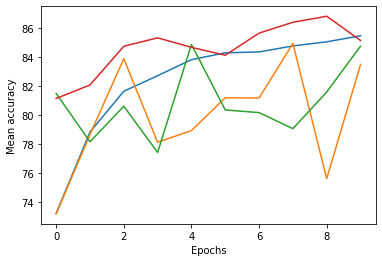

In [13]:
ax = None
dfs = {result.log_dir: result.metrics_dataframe for result in results}
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean accuracy")

## Hyperparameter optimization (ASAH Scheduler)

In [14]:
from ray.tune.schedulers import ASHAScheduler

scheduler = ASHAScheduler(
    max_t=config["epochs"], 
    time_attr="training_iteration",
    )

tuner = tune.Tuner(
    trainable,
    param_space = config,
    tune_config = tune.TuneConfig(
        metric = "mean_accuracy",
        mode = "max",
        num_samples = 16,
        scheduler=scheduler,
    )
)

results = tuner.fit()

2023-01-05 22:52:09,861	WARNING worker.py:1851 -- Warning: The actor ImplicitFunc is very large (45 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-01-05 22:52:10,023	WARNING util.py:244 -- The `start_trial` operation took 0.938 s, which may be a performance bottleneck.


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_tune_2ed79_00000,2023-01-05_22-55-30,True,,6432eba6f67f4143b250f8ffec05750c,fedora,10,90.0083,192.168.188.20,665005,198.454,17.1302,198.454,1672955730,0,,10,2ed79_00000,0.00344133
train_tune_2ed79_00001,2023-01-05_22-52-36,True,,9f0484ca456e4a49b55d084e1d3b8182,fedora,1,67.2333,192.168.188.20,665085,20.707,20.707,20.707,1672955556,0,,1,2ed79_00001,0.00464678
train_tune_2ed79_00002,2023-01-05_22-52-37,True,,2ee784c1e21147d4922742dcd6994df7,fedora,1,75.4917,192.168.188.20,665102,20.5935,20.5935,20.5935,1672955557,0,,1,2ed79_00002,0.00467539
train_tune_2ed79_00003,2023-01-05_22-52-37,True,,2c90b73e16fe415d8aad2cf7b15cc0a2,fedora,1,72,192.168.188.20,665134,20.4659,20.4659,20.4659,1672955557,0,,1,2ed79_00003,0.0043819
train_tune_2ed79_00004,2023-01-05_22-54-00,True,,9f0484ca456e4a49b55d084e1d3b8182,fedora,4,85.25,192.168.188.20,665085,83.5145,20.9458,83.5145,1672955640,0,,4,2ed79_00004,0.00464678
train_tune_2ed79_00005,2023-01-05_22-54-00,True,,2ee784c1e21147d4922742dcd6994df7,fedora,4,85.6833,192.168.188.20,665102,83.682,20.9106,83.682,1672955640,0,,4,2ed79_00005,0.00467539
train_tune_2ed79_00006,2023-01-05_22-52-58,True,,2c90b73e16fe415d8aad2cf7b15cc0a2,fedora,1,76.2083,192.168.188.20,665134,20.8088,20.8088,20.8088,1672955578,0,,1,2ed79_00006,0.0043819
train_tune_2ed79_00007,2023-01-05_22-53-18,True,,2c90b73e16fe415d8aad2cf7b15cc0a2,fedora,1,80.45,192.168.188.20,665134,20.8609,20.8609,20.8609,1672955598,0,,1,2ed79_00007,0.0043819
train_tune_2ed79_00008,2023-01-05_22-54-42,True,,2c90b73e16fe415d8aad2cf7b15cc0a2,fedora,4,85.2,192.168.188.20,665134,83.5106,21.0212,83.5106,1672955682,0,,4,2ed79_00008,0.0043819
train_tune_2ed79_00009,2023-01-05_22-54-20,True,,9f0484ca456e4a49b55d084e1d3b8182,fedora,1,77.925,192.168.188.20,665085,20.3995,20.3995,20.3995,1672955660,0,,1,2ed79_00009,0.00464678


2023-01-05 22:55:51,534	INFO tune.py:762 -- Total run time: 231.41 seconds (230.75 seconds for the tuning loop).


In [15]:
results.get_best_result()

Result(metrics={'mean_accuracy': 90.00833333333334, 'done': True, 'trial_id': '2ed79_00000', 'experiment_tag': '0_lr=0.0779,weight_decay=0.0007'}, error=None, log_dir=PosixPath('/home/raffi/ray_results/train_tune_2023-01-05_22-52-00/train_tune_2ed79_00000_0_lr=0.0779,weight_decay=0.0007_2023-01-05_22-52-09'))

Text(0, 0.5, 'Mean accuracy')

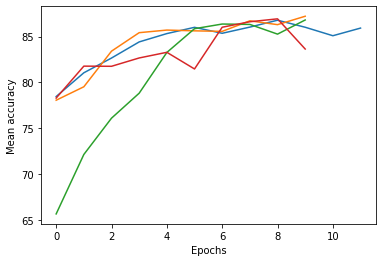

In [22]:
ax = None
dfs = {result.log_dir: result.metrics_dataframe for result in results}
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean accuracy")

## Hyperparameter optimization (PBT)

In [28]:
from ray.air import Checkpoint

def train_tune_pbt(config):
    step = 0
    epochs = config["epochs"]
    lr = config["lr"]
    weight_decay = config["weight_decay"]

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = NeuralNetwork().to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    if session.get_checkpoint():
        loaded_checkpoint = session.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            path = os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            checkpoint = torch.load(path)
            model.load_state_dict(checkpoint["model_state"])
            step = checkpoint["epoch"] 

    for t in range(step, epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_epoch(train_dataloader, model, loss_fn, optimizer, device)
        accuracy = test(val_dataloader, model, loss_fn, device)

        os.makedirs("model", exist_ok=True)
        torch.save(
            {
                "epoch": t,
                "model_state": model.state_dict(),
            },
            "model/checkpoint.pt"
        )
        checkpoint = Checkpoint.from_directory("model")
        session.report(metrics={"mean_accuracy": accuracy}, checkpoint=checkpoint)


In [29]:
from ray.tune.schedulers import PopulationBasedTraining

resources = {"cpu":4, "gpu":1} if torch.cuda.is_available() else {"cpu":4}
trainable = tune.with_resources(train_tune_pbt, resources=resources) 

scheduler = PopulationBasedTraining(
    time_attr = "epoch",
    perturbation_interval = 2,
    hyperparam_mutations = {
        "lr": tune.uniform(1e-1,1e-5),
        "weight_decay": tune.uniform(1e-2,1e-6)
    },
)

tuner = tune.Tuner(
    trainable,
    param_space = config,
    tune_config = tune.TuneConfig(
        metric = "mean_accuracy",
        mode = "max",
        num_samples = 4,
        scheduler=scheduler,
    )
)

results = tuner.fit()

2023-01-05 23:10:11,829	WARNING worker.py:1851 -- Warning: The actor ImplicitFunc is very large (45 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-01-05 23:10:12,059	WARNING util.py:244 -- The `start_trial` operation took 1.391 s, which may be a performance bottleneck.


Trial name,date,done,episodes_total,epoch,experiment_id,experiment_tag,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_tune_pbt_b6bc8_00000,2023-01-05_23-13-08,True,,9,d74f617a54294122ab34fd296c56dd7c,"0_lr=0.0675,weight_decay=0.0093@perturbed[lr=0.0080,weight_decay=0.0037]",fedora,1,87.025,192.168.188.20,671936,True,16.1841,16.1841,165.286,1672956788,0,,10,b6bc8_00000,0.017839
train_tune_pbt_b6bc8_00001,2023-01-05_23-13-04,True,,9,d74f617a54294122ab34fd296c56dd7c,"1_lr=0.0754,weight_decay=0.0047",fedora,10,85.1167,192.168.188.20,670912,True,166.35,17.2475,166.35,1672956784,0,,10,b6bc8_00001,0.00546169
train_tune_pbt_b6bc8_00002,2023-01-05_23-13-08,True,,9,d74f617a54294122ab34fd296c56dd7c,"2_lr=0.0104,weight_decay=0.0084@perturbed[lr=0.0603,weight_decay=0.0038]",fedora,7,84.8083,192.168.188.20,671358,True,115.397,16.2376,164.855,1672956788,0,,10,b6bc8_00002,0.0181437
train_tune_pbt_b6bc8_00003,2023-01-05_23-13-05,True,,9,8ff17f32684d4c92b9ad545d26e4c0bd,"3_lr=0.0408,weight_decay=0.0040",fedora,10,86.3,192.168.188.20,670965,True,165.744,17.1978,165.744,1672956785,0,,10,b6bc8_00003,0.0056715


2023-01-05 23:11:08,819	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial b6bc8_00001 (score = 84.358333) into trial b6bc8_00002 (score = 79.700000)

2023-01-05 23:11:08,820	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trialb6bc8_00002:
lr : 0.07537357756919381 --- (* 0.8) --> 0.060298862055355056
weight_decay : 0.004678232814140662 --- (resample) --> 0.0038490775857180715

2023-01-05 23:11:10,254	WARNING util.py:244 -- The `start_trial` operation took 0.515 s, which may be a performance bottleneck.
2023-01-05 23:12:09,939	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial b6bc8_00003 (score = 85.291667) into trial b6bc8_00000 (score = 84.325000)

2023-01-05 23:12:09,940	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trialb6bc8_00000:
lr : 0.04079606362146034 --- (* 1.2) --> 0.04895527634575241
weight_decay : 0.003960555544705935 --- (* 1.2) --> 0

In [30]:
results.get_best_result()

Result(metrics={'mean_accuracy': 87.02499999999999, 'epoch': 9, 'should_checkpoint': True, 'done': True, 'trial_id': 'b6bc8_00000', 'experiment_tag': '0_lr=0.0675,weight_decay=0.0093@perturbed[lr=0.0080,weight_decay=0.0037]'}, error=None, log_dir=PosixPath('/home/raffi/ray_results/train_tune_pbt_2023-01-05_23-10-06/train_tune_pbt_b6bc8_00000_0_lr=0.0675,weight_decay=0.0093_2023-01-05_23-10-10'))

Text(0, 0.5, 'Mean accuracy')

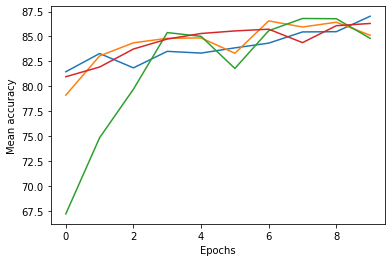

In [31]:
ax = None
dfs = {result.log_dir: result.metrics_dataframe for result in results}
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean accuracy")